**Data Cleaning:** Correction of inconsistencies.

* Age variable:

    * (remove values < 0)
    * categorize into under_age, 20s-40s, 40s+

**Sampling**: Is it worth performing UnderSampling on the training set for vr = 1? The fraud rate is very high compared to a real-world scenario; some characteristics found in the dataframe, such as categories of certain variables, have very balanced distributions, which is also not very common in a real-world scenario. Opt to leave fraud rate as original in the dataset.

**Feature Engineering:** Create new features from existing ones that can be informative for fraud detection (e.g., transaction frequency per customer, average transaction value per customer, consistency between IP and delivery address, account age at the time of transaction, etc.).

**Data Transformation:** In real-world scenarios, I wouldn't use label encoding for data transformation because of the risk of high cardinality in the dataframe columns. 


In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier


In [200]:
df_ini = pd.read_pickle("/Users/marianamatos/ppgti/data-centric-ia/weak-supervised-fraud-detection/data/df_new_features.pkl")
df_ini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23634 entries, 0 to 23633
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   transaction_id             23634 non-null  object        
 1   customer_id                23634 non-null  object        
 2   transaction_amount         23634 non-null  float64       
 3   transaction_date           23634 non-null  datetime64[ns]
 4   payment_method             23634 non-null  object        
 5   product_category           23634 non-null  object        
 6   quantity                   23634 non-null  int64         
 7   customer_age               23634 non-null  int64         
 8   customer_location          23634 non-null  object        
 9   device_used                23634 non-null  object        
 10  ip_address                 23634 non-null  object        
 11  shipping_address           23634 non-null  object        
 12  bill

### Data Cleaning

Drop customer_age < 0

In [201]:
df_ini = df_ini[~(df_ini['customer_age'] < 0)]

df_ini.shape[0]

23633

In [161]:
df_ini = df_ini[~(df_ini['account_age_days'] < 0)]

df_ini.shape[0]

23633

### Feature Engineering

Transaction amount avegare per age is around 226.76 ~ 231.26. So i decided not to use customer_age categorical with transaction_amount. I will only work with the transaction_amout creating a variable that informs if a transaction had a high amount above the outliers que found on notebook 1



In [162]:
# categorical column for customer_age

df_ini.loc[(df_ini['customer_age'] >= 0)
           & (df_ini['customer_age'] < 10),
        'cat_customer_age',
        ] = 'child'

df_ini.loc[(df_ini['customer_age'] >= 10)
           & (df_ini['customer_age'] < 18),
        'cat_customer_age',
        ] = 'under_age'

df_ini.loc[(df_ini['customer_age'] >= 18)
           & (df_ini['customer_age'] < 40),
        'cat_customer_age',
        ] = '20s - 30s'

df_ini.loc[(df_ini['customer_age'] >= 40)
           & (df_ini['customer_age'] < 60),
        'cat_customer_age',
        ] = '40 - 50s'

df_ini.loc[(df_ini['customer_age'] >= 60),
        'cat_customer_age',
        ] = '60s +'

In [163]:
df_ini.transaction_hour.min()

np.int64(0)

In [164]:
# categorical column for transaction_hour
df_ini.loc[(df_ini['transaction_hour'] >= 0)
           & (df_ini['transaction_hour'] < 6),
        'cat_transaction_hour',
        ] = 'overnight'

df_ini.loc[(df_ini['transaction_hour'] >= 6)
           & (df_ini['transaction_hour'] <= 12),
        'cat_transaction_hour',
        ] = 'morning'

df_ini.loc[(df_ini['transaction_hour'] >= 13)
           & (df_ini['transaction_hour'] <= 17),
        'cat_transaction_hour',
        ] = 'evening'

df_ini.loc[(df_ini['transaction_hour'] > 17)
           & (df_ini['transaction_hour'] <= 23),
        'cat_transaction_hour',
        ] = 'night'



In [165]:
df_ini.account_age_days.max()

np.int64(365)

In [166]:
# categorical column for account_age_days (bool)
# 1: 1-61
# 0: 90 > 
df_ini['is_new_account'] = np.where(df_ini['account_age_days'] > 61, 0, 1)

In [ ]:
# categorical column for transaction_amount
import pandas as pd

def categorize_transaction_amount(amount):
    if amount <= 150:  # Aprox. valid transaction median
        return 'low amount'
    elif amount <= 286: # Q3 for valid transactions (is_fraudulant = 0)
        return 'medium amount'
    else:
        return 'high amount'

df_ini['cat_transaction_amount'] = df_ini['transaction_amount'].apply(categorize_transaction_amount)

print("\nCom categorias revisadas:")
print(df_ini[['transaction_amount', 'is_fraudulent', 'cat_transaction_amount']].head(10))



Com categorias revisadas:
   transaction_amount  is_fraudulent cat_transaction_amount
0               42.32              0             low amount
1              301.34              0            high amount
2              340.32              0            high amount
3               95.77              0             low amount
4               77.45              0             low amount
5              345.27              0            high amount
6               53.69              0             low amount
7              680.17              0            high amount
8              126.50              0             low amount
9               47.18              0             low amount


In [168]:
# df_ini[df_ini['cat_valor_fraude_rev']== "Alto Valor"][['transaction_amount', 'is_fraudulent']]

# df_ini.groupby('cat_valor_fraude_rev')['is_fraudulent'].describe()



Dosen't help

In [169]:
# gasto médio por faixa de idade (cat)
# client_age_amout_upper_avg (bool) - cat_customer_age + avg_amout_per_age

transaction_amout_per_age = df_ini.groupby('cat_customer_age')['transaction_amount'].mean().reset_index()
transaction_amout_per_age.rename(columns={'transaction_amount': 'avg_transaction_amout_per_age'}, inplace=True)

# df_ini = pd.merge(df_ini, transaction_amout_per_age, on='cat_customer_age', how='left')

In [170]:
# # transaction_amount

# **cat_valor_fraude_rev X cat_transaction_hour**  
# **cat_valor_fraude_rev x is_new_account**

In [198]:
df_ini.columns

Index(['payment_method', 'product_category', 'quantity', 'device_used',
       'is_fraudulent', 'common_customer_location', 'address_ip_relationship',
       'is_ip_address_double', 'shipping_address_repeated',
       'billing_address_repeated', 'day_of_week', 'month', 'cat_customer_age',
       'cat_transaction_hour', 'is_new_account', 'cat_transaction_amount'],
      dtype='object')

In [ ]:
df_ini = df_ini.drop(["customer_id","customer_location","transaction_date","ip_address","shipping_address","billing_address"], axis=1)

In [191]:
X_raw = df_ini[['payment_method', 'product_category', 'quantity', 'device_used', 'common_customer_location', 'address_ip_relationship',
       'is_ip_address_double', 'shipping_address_repeated',
       'billing_address_repeated', 'day_of_week', 'month', 'cat_customer_age',
       'cat_transaction_hour', 'is_new_account', 'cat_transaction_amount']]
y = df_ini["is_fraudulent"]

### Normalization/padronization


In [ ]:
# df_ini = df_ini.drop(["customer_id","customer_location","transaction_date","ip_address","shipping_address","billing_address"], axis=1)

Caterorical

In [192]:
# One-hot encode categorical features
categorical_features = ["is_new_account","payment_method", "product_category","device_used", "cat_transaction_amount", "cat_transaction_hour", "cat_customer_age", "month",  "is_ip_address_double", "address_ip_relationship", "common_customer_location"]
X_encoded = pd.get_dummies(X_raw, columns=categorical_features, drop_first=True)

In [ ]:
# df_ini['payment_method'] = df_ini['payment_method'].map({"debit card":0,"credit card":1,"PayPal":2,"bank transfer":3})

# df_ini['product_category'] = df_ini['product_category'].map({"home & garden":0,"electronics":1,"toys & games":2,"clothing":3,"health & beauty":4})

# df_ini['device_used'] = df_ini['device_used'].map({"desktop":0,"mobile":1,"tablet":2,})

# df_ini['cat_transaction_amount'] = df_ini['cat_transaction_amount'].map({"low amount":0,"medium amount":1,"high amount":2,})

# df_ini['cat_transaction_hour'] = df_ini['cat_transaction_hour'].map({"morning":0,"evening":1,"night":2, "overnight":3})

# df_ini['cat_customer_age'] = df_ini['cat_customer_age'].map({"child":0,"under_age":1,"20s - 30s":2, "40 - 50s":3 , "60s +":4})
# df_ini['month'] = df_ini['month'].map({"January":0,"February":1,"March":2, "April":3})

# df_ini['day_of_week'] = df_ini['day_of_week'].map({"Monday":0,"Tuesday":1,"Wednesday":2, "Thursday":3 , "Friday":4, "Saturday":5, "Sunday":6})

# df_ini['is_ip_address_double'] = df_ini['is_ip_address_double'].map({"not_double":0,"double_ip":1,"double_address":2})
# df_ini['address_ip_relationship'] = df_ini['address_ip_relationship'].map({"different_ip_same_address":0,"different_ip_different_address":1})

# df_ini['common_customer_location'] = df_ini['common_customer_location'].map({"common":0,"not common":1})



Numerical

In [193]:
numeric_features = ['quantity']
scaler = StandardScaler()
X_encoded[numeric_features] = scaler.fit_transform(X_encoded[numeric_features])
print(X_encoded.head())

   quantity  shipping_address_repeated  billing_address_repeated  day_of_week  \
0 -1.409172                      False                     False            6   
1 -0.000387                      False                     False            0   
2  1.408397                      False                     False            0   
3  1.408397                      False                     False            1   
4  1.408397                      False                     False            1   

   is_new_account_1  payment_method_1  payment_method_2  payment_method_3  \
0             False             False              True             False   
1             False              True             False             False   
2             False             False             False             False   
3             False              True             False             False   
4             False              True             False             False   

   product_category_1  product_category_2  ...  ca

In [ ]:
# numeric_features = ['transaction_amount', 'quantity', 'customer_age', 'account_age_days', 'transaction_hour']
# scaler = StandardScaler()
# df_ini[numeric_features] = scaler.fit_transform(df_ini[numeric_features])


In [174]:
df_ini.head()

,transaction_id,transaction_amount,payment_method,product_category,quantity,customer_age,device_used,is_fraudulent,account_age_days,transaction_hour,...,is_ip_address_double,shipping_address_repeated,billing_address_repeated,is_addrss_ship_bill,day_of_week,month,cat_customer_age,cat_transaction_hour,is_new_account,cat_transaction_amount
0,c12e07a0-8a06-4c0d-b5cc-04f3af688570,-0.663184,2,1,-1.409172,0.543463,0,0,0.962333,1.680961,...,0,False,False,True,6,2,3,2,0,0
1,7d187603-7961-4fce-9827-9698e2b6a201,0.255175,1,1,-0.000387,0.043795,2,0,0.412921,-1.613877,...,0,False,False,True,0,0,2,3,0,2
2,f2c14f9d-92df-4aaf-8931-ceaf4e63ed72,0.393379,0,2,1.408397,-0.555806,0,0,1.688674,-0.467847,...,0,False,False,False,0,0,2,0,0,2
3,e9949bfa-194d-486b-84da-9565fca9e5ce,-0.473676,1,1,1.408397,1.043131,1,0,1.362752,1.251199,...,0,False,False,True,1,0,3,2,0,0
4,7362837c-7538-434e-8731-0df713f5f26d,-0.538630,1,3,1.408397,0.743330,0,0,-0.583470,0.534930,...,0,False,False,True,1,0,3,1,0,0


In [ ]:
# # Drop correlated features
# df_ini.drop(columns=['transaction_id','transaction_amount', 'account_age_days', 'customer_age', 'transaction_hour', 'is_addrss_ship_bill'], inplace=True)

<Axes: >

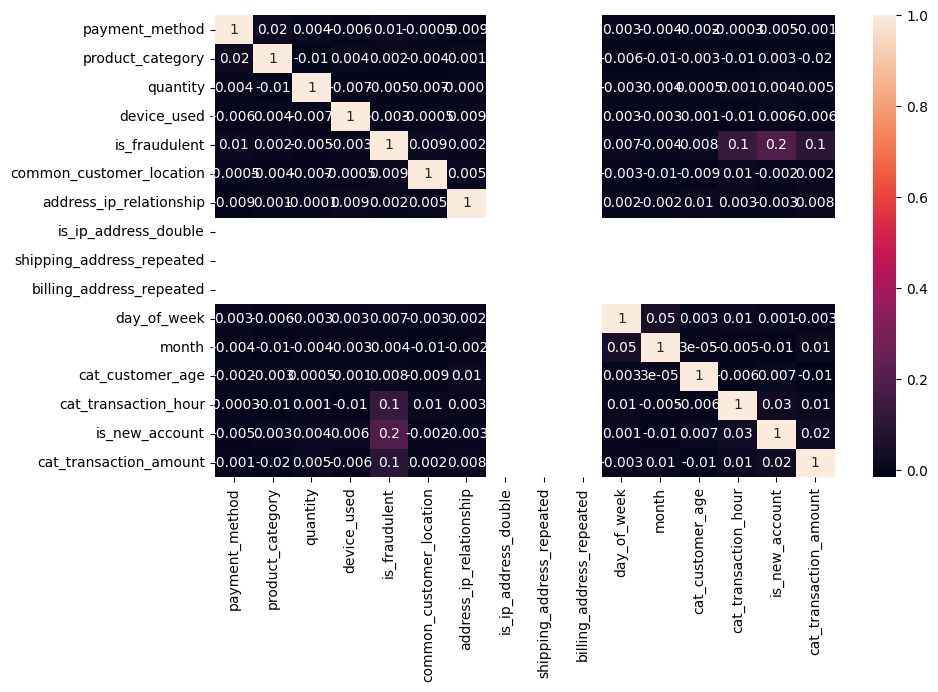

In [196]:
plt.figure(figsize=(10,6))
sns.heatmap(df_ini.corr(),annot=True, fmt='.1g')

### Split train/test

In [ ]:
# X = df_ini.drop('is_fraudulent', axis=1)
# y = df_ini['is_fraudulent']
# X.shape, y.shape

((23633, 15), (23633,))

In [ ]:
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=37)

In [ ]:
# train_data = pd.concat([X_train, y_train], axis=1)

In [199]:
X_encoded.to_pickle("/Users/marianamatos/ppgti/data-centric-ia/weak-supervised-fraud-detection/data/X_encoded.pkl")
y.to_pickle("/Users/marianamatos/ppgti/data-centric-ia/weak-supervised-fraud-detection/data/y.pkl")
df_ini.to_pickle("/Users/marianamatos/ppgti/data-centric-ia/weak-supervised-fraud-detection/data/df_ini.pkl")
# y_test.to_pickle("/Users/marianamatos/ppgti/data-centric-ia/weak-supervised-fraud-detection/data/y_test.pkl")

In [181]:
train_data.to_pickle("/Users/marianamatos/ppgti/data-centric-ia/weak-supervised-fraud-detection/data/train_data.pkl")